***SPEECH EMOTION RECOGNITION***

'RAVDESS-emotional-speech-audio' dataset is widely used for speech-emotion-recognition.
It contains: 2452 audio files, with 12 male speakers and 12 Female speakers, the lexical features (vocabulary) of the utterances are kept constant by speaking only 2 statements of equal lengths in 8 different emotions by all speakers.

* 0 = neutral
* 1 = calm
* 2 = happy
* 3 = sad
* 4 = angry
* 5= fearful
* 6 = disgust
* 7 = surprised

In [3]:
# Importing required libraries/dependencies
import numpy as np 
import pandas as pd 
import os 
import librosa # FOR SPEECH Processing
import wave # To read/write WAV files
import matplotlib.pyplot as plt 

# LSTM Classifier
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop
from tensorflow.python.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

Defining a function to extract mfcc features & obtain the mean of each dimension

In [4]:
def extract_mfcc(wav_file_name):

    y, sr = librosa.load(wav_file_name,duration=3,offset=0.5)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

Loading Speech Data (RAVDESS Dataset)

In [5]:
radvess_speech_labels = [] # to save extracted label/file
ravdess_speech_data = [] # to save extracted features/file
for dirname, _, filenames in os.walk('/kaggle/input/ravdess-emotional-speech-audio/'):
    for filename in filenames:
      
        radvess_speech_labels.append(int(filename[7:8]) - 1) # the index 7 and 8 of the file name represent the emotion label
        wav_file_name = os.path.join(dirname, filename)
        ravdess_speech_data.append(extract_mfcc(wav_file_name)) # extract MFCC features/file
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [6]:
### convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data) # convert the input to an array
ravdess_speech_label_array = np.array(radvess_speech_labels)
ravdess_speech_label_array.shape # get tuple of array dimensions

#### make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array) # converts a class vector (integers) to binary class matrix
labels_categorical.shape

(2880, 8)

In [7]:
ravdess_speech_data_array.shape

(2880, 40)

Splitting data into training & testing parts

In [8]:
x_train,x_test,y_train,y_test= train_test_split(np.array(ravdess_speech_data_array),labels_categorical, 
                                                test_size=0.20, random_state=9)

In [9]:
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

Making an LSTM Model

In [83]:
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(16, return_sequences=False, input_shape=(40, 1)))
    model.add(Dense(16))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [84]:
w = np.expand_dims(ravdess_speech_data_array[:training_samples],-1)
w.shape

TRAINING LSTM Model

In [97]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) #Early Stopping

model_A = create_model_LSTM()
history = model_A.fit(np.expand_dims(ravdess_speech_data_array[:training_samples],-1), 
                      labels_categorical[:training_samples], 
                      validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), 
                      epochs=50, callbacks=[es_callback])

Epoch 1/50
72/72 [==============================] - 3s 21ms/step - loss: 2.1155 - accuracy: 0.1236 - val_loss: 2.0657 - val_accuracy: 0.1493
Epoch 2/50
72/72 [==============================] - 1s 13ms/step - loss: 2.0722 - accuracy: 0.1413 - val_loss: 2.0486 - val_accuracy: 0.1875
Epoch 3/50
72/72 [==============================] - 1s 13ms/step - loss: 2.0560 - accuracy: 0.1500 - val_loss: 2.0412 - val_accuracy: 0.1840
Epoch 4/50
72/72 [==============================] - 1s 13ms/step - loss: 2.0416 - accuracy: 0.1724 - val_loss: 2.0260 - val_accuracy: 0.1944
Epoch 5/50
72/72 [==============================] - 1s 13ms/step - loss: 2.0220 - accuracy: 0.1962 - val_loss: 2.0087 - val_accuracy: 0.2118
Epoch 6/50
72/72 [==============================] - 1s 15ms/step - loss: 1.9982 - accuracy: 0.2266 - val_loss: 1.9932 - val_accuracy: 0.2083
Epoch 7/50
72/72 [==============================] - 1s 14ms/step - loss: 1.9830 - accuracy: 0.2314 - val_loss: 1.9853 - val_accuracy: 0.2257
Epoch 8/50
72

Loss plots of the built LSTM model


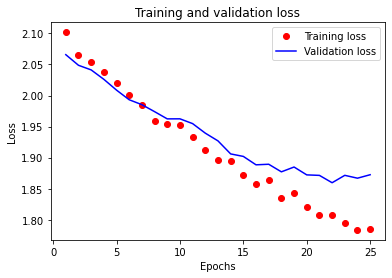

In [98]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Accuracy plots of the built LSTM model

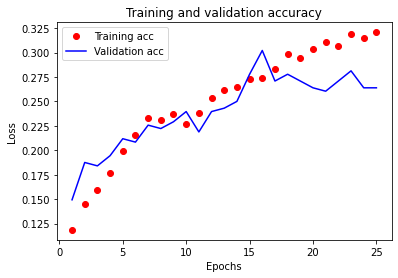

In [99]:
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [101]:
model_A.save_weights("Model_LSTM.h5")

In [108]:
#path_ = '/kaggle/input/audioinput/focus.wav'
path_ = '../input/audio-input-file/taunt.wav'
#path_ = '../input/audio-input-file/preamble.wav'

In [109]:
import IPython.display as ipd
ipd.Audio(path_)

In [110]:
a = extract_mfcc(path_)
a.shape
a1 = np.asarray(a)
a1.shape

(40,)

In [111]:
q = np.expand_dims(a1,-1)
qq = np.expand_dims(q,0)
qq.shape

(1, 40, 1)

In [112]:
pred = model_A.predict(qq)
pred

array([[0.03315116, 0.05077701, 0.09413864, 0.17455882, 0.04898958,
        0.49835777, 0.09208273, 0.00794427]], dtype=float32)

In [113]:
preds=pred.argmax()
preds

5

* #0 = neutral
* #1 = calm
* #2 = happy
* #3 = sad
* #4 = angry
* #5= fearful
* #6 = disgust
* #7 = surprised